# MovieLens recommender system

We consider here the dataset MovieLens  (Harper and Konstan, 2015) that contains 100,000 ratings given by 943 users
to 1682 movies. Each user has rated at least 20 movies and demographic information is available for each user.

The dataset can be downloaded by running the following code

In [1]:
import os
from subprocess import call
# change the following boolean to download the data
NOT_RUN = True

if NOT_RUN:
    file_dir = 'ml-100k'
    file_path = os.path.join(file_dir, 'u.data')
    if not os.path.isdir(file_dir):
        call(['curl', '-O', 'http://files.grouplens.org/datasets/movielens/' + file_dir + '.zip'])
        call(['unzip', file_dir + '.zip'])

### Load dataset

We now load the dataset in the preference format. We use the utility function `generateMovieChoiceData` which generates the vector of input features `largeX` and the vector of all preferences `Allchoices1v`.

In [2]:
import sys
sys.path.append('../')
from utility.generate_movieData import generateMovieChoiceData

In [3]:
largeX, Allchoices1v = generateMovieChoiceData(nmovies=650,nusers=100,dir_to_save=None)

Reading data from folder ./ml-100k ...
data dimension: 
 (100000, 4)


/Users/dario.azzimonti/Library/CloudStorage/Dropbox/GPpref/notebooks/../utility/generate_movieData.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[ratings_col] = 1


number of movies selected:  650
Size of users/movies matrix  (50, 650)
Size of user features  (50, 24)
Size of tiled input feature vector: (32500, 25)
Total number of choices:  2678506


### Set up the model

We now set up the training test split and the model. Note that this model is implemented in gpytorch. This allows us to use stochastic gradient descent with mini-batches to optimize a variational sparse model. We need stochastic variational inference in this example because the number of pairwise preferences is too large. 

In [4]:
import torch
from model.choiceGPytorch import ChoiceGPtorch
from sklearn.model_selection import train_test_split
import numpy as np

torch.set_default_dtype(torch.float32)
dtype=torch.float32
device = torch.device("cpu")

In [5]:
# split in training and testing
Allchoices1v_tr,Allchoices1_te= train_test_split(Allchoices1v,test_size=0.2)
CA=Allchoices1v_tr[:,[0]]
RA=Allchoices1v_tr[:,[1]]

#since we consider preferences
dimA=2 #dimension of choice set
num_latents = 1 # number of latent utilities


#this is just for the function 
CAt=np.hstack([CA,-1*np.ones((CA.shape[0],1))])
RAt=np.hstack([RA,-1*np.ones((RA.shape[0],1))])


target = torch.stack((torch.tensor(CAt,device=device), torch.tensor(RAt,device=device))).type(torch.int32)
Xtrain = torch.from_numpy(largeX).type(dtype).to(device)#.squeeze()

In [6]:
# Let's use a different set of inducing points for each task
n_ind=800 # number of inducing points
indx = np.random.choice(Xtrain.shape[0], n_ind, replace=False)
# we select the initial position of the inducing points as a subset of the input features
inducing_points = largeX[indx,:]
inducing_points = inducing_points.astype(np.float32)
inducing_points = torch.from_numpy(inducing_points).to(device)
inducing_points = inducing_points.reshape(1,n_ind,Xtrain.shape[1])

print(target.shape, Xtrain.shape ,inducing_points.shape)

torch.Size([2, 2142804, 2]) torch.Size([32500, 25]) torch.Size([1, 800, 25])


In [7]:
model = ChoiceGPtorch(dimA=dimA,num_gp=num_latents,num_choices=target.shape[1],
                      inducing_points=inducing_points,
                      learn_inducing_locations=True,
                      use_batches=True)

In [8]:
from utility.choice_dataset import ChoiceDataset

batch_size = 5096
dataset = ChoiceDataset(Xtrain, target[0], target[1])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=dataset.collate_fn, shuffle=True)


In [9]:
# This cell requires about 50 min per iteration to compute.
# model.optimize_batches(dataloader, num_iterations=16, lr=0.035)
# model_name='./saved_models/nChoices_2_6M_input_32k_indPts_800_it_16'
# model.save(model_name)

In [10]:
# This cell loads the trained model.
model_name='./saved_models/nChoices_2_6M_input_32k_indPts_800_it_16'
model.load(model_name)

In [11]:
meanf,varf,lower,upper= model.predict(Xtrain,covariance=False)

pred=meanf[:,None][Allchoices1_te][:,:,0]
pred_var = varf[:,None][Allchoices1_te][:,0,0]

print("Accuracy:")
print(np.mean(pred[:,0]>pred[:,1])) 

Accuracy:
0.9067709286132962


In [12]:
import scipy
Ww=pred[:,0,0]-pred[:,1,0]
prob_test = scipy.stats.norm.cdf(Ww/np.sqrt(pred_var[:,0]))

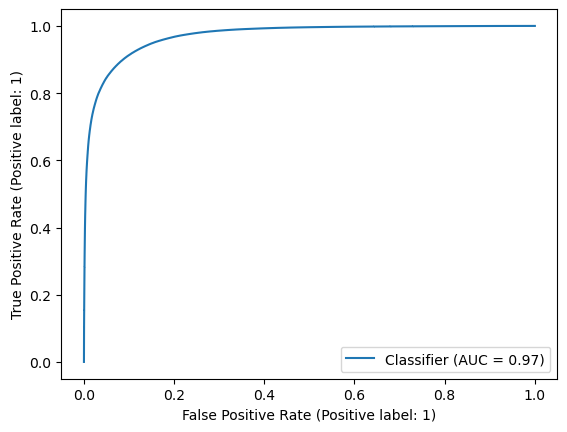

In [13]:
from sklearn.metrics import precision_recall_curve,PrecisionRecallDisplay,RocCurveDisplay
RocCurveDisplay.from_predictions(np.hstack((np.ones_like(prob_test),np.zeros_like(prob_test))), 
                                        np.hstack((prob_test,1-prob_test)))